In [54]:
from __future__ import division
from math import *
import numpy as np
import scipy as sp
from scipy import stats, linalg
import pandas as pd
pd.options.display.mpl_style = 'default'

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline


#from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from scipy import stats

In [3]:
df_test = pd.read_csv('datasets/Translation_Test/test_table.csv')
df_test.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
df_user = pd.read_csv('datasets/Translation_Test/user_table.csv')
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
np.unique(df_user.user_id).shape[0] == df_user.shape[0]

True

so no duplicates.

In [6]:
print df_test.shape[0]
print df_user.shape[0]

453321
452867


It seems that there are 454 users not in the users table, so we do an outer join not to lose data.

In [192]:
df = pd.merge(df_test, df_user, on='user_id', how='outer')
df_inner = pd.merge(df_test, df_user, on='user_id')

tmp = pd.concat([df_inner, df]).reset_index(drop=True)
df_gpby = tmp.groupby(list(tmp.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]

tmp.ix[idx].head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
888790,191496,2015-12-01,SEO,Web,ES,NaN,Safari,0,0,NaN,NaN,NaN
478115,781591,2015-11-30,Ads,Web,ES,Facebook,Chrome,1,1,NaN,NaN,NaN
889709,376911,2015-12-01,Ads,Mobile,ES,Google,Android_App,0,1,NaN,NaN,NaN
808854,780557,2015-11-30,Direct,Web,EN,NaN,Chrome,0,1,NaN,NaN,NaN
878926,357662,2015-12-03,Ads,Web,ES,Yahoo,Chrome,0,0,NaN,NaN,NaN


In [7]:
df = pd.merge(df_test, df_user, on='user_id')
df.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [8]:
df.describe(include=['object'])

,date,source,device,browser_language,ads_channel,browser,sex,country
count,452867,452867,452867,452867,181693,452867,452867,452867
unique,5,3,2,3,5,7,2,17
top,2015-12-04,Ads,Web,ES,Facebook,Android_App,M,Mexico
freq,141024,181693,251316,377160,68358,154977,264485,128484


In [9]:
np.unique(df_test['date'])

array(['2015-11-30', '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04'], dtype=object)

The test happened in 5 consecutive days starting Nov 30th.

In [10]:
df.groupby('browser_language').size()

browser_language
EN        63079
ES       377160
Other     12628
dtype: int64

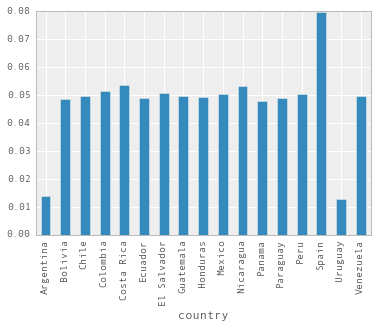

In [11]:
df.groupby('country')['conversion'].aggregate(np.mean).plot(kind='bar')

That's right. Spain does much better in conversion.

First I would like to divide the data based on tested or not tested. Then ratio of conversion is compared in two groups.

In [13]:
df_test = df[df.browser_language=='ES'][df.country!='Spain']
df0 = df_test[df.test==0]
df1 = df_test[df.test==1]

In [14]:
df0_converted = df0[df0.conversion==1]
df0_converted.shape[0]/df0.shape[0]

0.04862190446585846

conversion percentage in users not in the test is %4.8

In [15]:
df1_converted = df1[df1.conversion==1]
df1_converted.shape[0]/df1.shape[0]

0.04351941558369247

conversion percentage in users in the test is %4.3

Based on conversion rates we hypothesize that the changes in the website decrease conversion. Now we need to test the hypothesis. We have observed two independent samples from two different populations. The test measures whether the mean is significantly different across two samples. 

Null Hypothesis: mu0=mu1

Alternative Hypothesis: mu1<mu0

In [17]:
np.random.seed(12345678)
group0 = df0['conversion']
group1 = df1['conversion']
n0 = group0.shape[0]
n1 = group1.shape[0]
stats.ttest_ind(group1, group0)

Ttest_indResult(statistic=-7.0278392111587609, pvalue=2.1015510425902569e-12)

In [66]:
stats.ttest_ind(group1, group0)[1]

2.1015510425902569e-12

Testing things manually to double check!

In [18]:
var0 = (n0-1)*np.var(group0)
var1 = (n1-1)*np.var(group1)
sp = sqrt((var0+var1)/(n0+n1-2))
t_stat = (np.mean(group1)-np.mean(group0))/(sp*sqrt((1/n0)+(1/n1)))
t_stat
#pval = stats.t.sf(t_stat,n0+n1-2)

-7.027860335742952

In [93]:
def ttest(mu1,mu2,v1,v2,n1,n2):
    var1 = (n1-1)*v1
    var2 = (n2-1)*v2
    sp = sqrt((var1+var2)/(n1+n2-2))
    t_stat = (mu1-mu2)/(sp*sqrt((1/n1)+(1/n2)))
    return t_stat

The p-value show statistical significance, and Null hypothesis is rejected. Therefore the conversion drops significantly after the test. Something wierd is happening, either we did not collect enough data or there is some sort of sampling bias in test/control groups.

Let's plot daily conversions.

In [21]:
d1 = np.array(df1.groupby('date')['conversion'].aggregate(np.mean))
d1

array([ 0.04480204,  0.04124296,  0.04424366,  0.04380599,  0.04345803])

In [22]:
d0 = np.array(df0.groupby('date')['conversion'].aggregate(np.mean))
d0

array([ 0.0513286 ,  0.04743982,  0.048835  ,  0.04938344,  0.04720385])

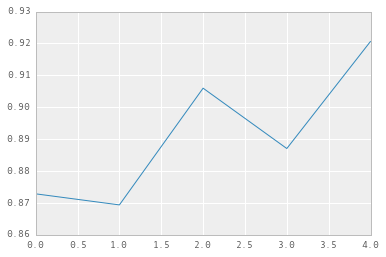

In [23]:
plt.plot(d1 / d0)

test has been constantly worse that control with little variance across days, meaning we there has been bias in the experiment design, meaning the users selected as test/control are not chosen completely random, and perhaps they are selected from segments with a significantly smaller or larger conversion rate.

One way to check that is to train a classifier on user variables and outcome of test or control user. If the classifier does not perform random split, it means that there has been a bias in test/control user selection.

In [28]:
X = df_test.copy()
del X['conversion']
del X['test']
del X['user_id']
del X['ads_channel']
X.head(5)

,date,source,device,browser_language,browser,sex,age,country
1,2015-12-04,Ads,Web,ES,IE,M,21,Mexico
4,2015-11-30,Ads,Web,ES,FireFox,M,19,Mexico
5,2015-12-03,Direct,Mobile,ES,Android_App,F,22,Venezuela
8,2015-12-04,Direct,Mobile,ES,Android_App,M,31,Bolivia
9,2015-12-04,Ads,Mobile,ES,Android_App,F,33,Mexico


In [39]:
tree = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.01*X.shape[0])

In [29]:
def categorical_encoder(df, names):
    le = preprocessing.LabelEncoder()
    for name in names:
        le.fit(np.unique(df[name]))
        df[name] = df[name].map(lambda x:le.transform(x))

In [30]:
names = [str(item) for item in X.select_dtypes(include=['object']).columns]
categorical_encoder(X, names)

In [40]:
tree.fit(X, df_test['test'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_samples_leaf=3340.14, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best')

In [41]:
tree.tree_.compute_feature_importances()

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.38173180e-04,
         0.00000000e+00,   9.99861827e-01])

It looks like country is the important feature for the split

In [42]:
tree.tree_.impurity

array([ 0.49715802,  0.31980301,  0.32445193,  0.31641254,  0.49998198,
        0.49999622,  0.49657341])

http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html

In [60]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [61]:
visualize_tree(estimator, X.columns)

In [82]:
df0.groupby('country')['conversion'].agg( lambda x: np.mean(x))

country
Argentina      0.015398
Bolivia        0.049565
Chile          0.048293
Colombia       0.052884
Costa Rica     0.051457
Ecuador        0.050400
El Salvador    0.054678
Guatemala      0.049898
Honduras       0.050605
Mexico         0.049972
Nicaragua      0.054026
Panama         0.047912
Paraguay       0.047223
Peru           0.049392
Uruguay        0.008427
Venezuela      0.050712
Name: conversion, dtype: float64

In [80]:
df1.groupby('country')['conversion'].agg( lambda x: np.mean(x))


country
Argentina      0.014069
Bolivia        0.049420
Chile          0.049688
Colombia       0.051011
Costa Rica     0.053162
Ecuador        0.048803
El Salvador    0.048882
Guatemala      0.051307
Honduras       0.048995
Mexico         0.050938
Nicaragua      0.054572
Panama         0.051745
Paraguay       0.047047
Peru           0.050464
Uruguay        0.010975
Venezuela      0.049830
Name: conversion, dtype: float64

Given the bias in sampling based on country, we perform AB test after grouping by country.

In [92]:
for country in [str(item) for item in np.unique(df_test.country)]:
    test = df_test[df_test.country==country][df_test.test==1]['conversion']
    control = df_test[df_test.country==country][df_test.test==0]['conversion']
    print 'p-value for', country, 'is' ,stats.ttest_ind(test, control)[0]

p-value for Argentina is -0.883368552224
p-value for Bolivia is -0.0322322015521
p-value for Chile is 0.414087819172
p-value for Colombia is -0.893610077154
p-value for Costa Rica is 0.253297496452
p-value for Ecuador is -0.423452978831
p-value for El Salvador is -1.07613392116
p-value for Guatemala is 0.360838867264
p-value for Honduras is -0.313263023221
p-value for Mexico is 0.721881175699
p-value for Nicaragua is 0.0904072942932
p-value for Panama is 0.504993901048
p-value for Paraguay is -0.0323526553066
p-value for Peru is 0.411610853244
p-value for Uruguay is 0.442145239446
p-value for Venezuela is -0.329812303369


non seem significant after controlling for country.